In [2]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [3]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [4]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

387047
16.049999237060547 35.887664794921875 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.0880889892578125, 0.8147430419921875, 0.1421051025390625]


Now we have everything stored in routes. Time to generate some test data

In [21]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 200
fwd_data = [20, 40, 60, 80, 100]


all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
test_routes = [randrange(all_routes) for _ in range(test_count)]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes]

group_base = 1
group_IMU = 5
base_size = prev_data//group_base
IMU_size = prev_data//group_IMU
torque_size = (prev_data + fwd_data[-1])//group_base

input_length = 2 * base_size + 6*IMU_size + torque_size
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data[-1]]/maxTorque
            
            phi = phi.reshape(-1, group_base).mean(axis=1)
            v = v.reshape(-1, group_base).mean(axis=1)
            M = M.reshape(-1, group_base).mean(axis=1)
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, group_IMU).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, group_IMU).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = route.phi[idx+fwd_data[i]]/maxAngle
            data = (phi, v, M, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2])
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set))

  0%|          | 0/22 [00:00<?, ?it/s]

26 routes


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

66777 9083


In [22]:
t0 = train_set[0][0]
print(t0.shape)
print(input_length)

(940,)
940


In [23]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

1043
142


In [35]:
# base_size = prev_data//group_base
# IMU_size = prev_data//group_IMU
# torque_size = (prev_data + fwd_data)//group_base
print(f"Base, IMU, M, {(base_size, IMU_size, torque_size)}")
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_length),
            nn.Tanh()
        )
#         self.baseStack = nn.Sequential(
#             nn.Linear(base_size, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#             nn.ReLU(),
#         )
        
#         self.torqueStack = nn.Sequential(
#             nn.Linear(torque_size, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16),
#             nn.ReLU(),
#         )
#         self.IMUStack = [nn.Sequential(
#             nn.Linear(IMU_size, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#             nn.ReLU(),
#         ) for _ in range(6)]
        
#         self.linearStack = nn.Sequential(
#             nn.Linear(80, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1),
#             nn.Tanh(),
#         )
        
    def forward(self, x):
#         phi = x[:,0:base_size]
#         v = x[:,base_size:2*base_size]
#         M = x[:,2*base_size: 2*base_size+torque_size]
        
#         step = 2*base_size+torque_size
#         IMU_emb = [None]*6
#         for i in range(6):
#             IMU_emb[i] = x[:,step + i*IMU_size: step + (i+1)*IMU_size]
#         phi2 = self.baseStack(phi)
#         v2 = self.baseStack(v)
#         M2 = self.torqueStack(M)
#         IMU_emb2 = [None]*6
#         for i in range(6):
#             IMU_emb2[i] = self.IMUStack[i](IMU_emb[i])
        
#         emb = torch.cat((phi2, v2, M2)+tuple(IMU_emb2), dim=1)
#         return self.linearStack(emb)
        return self.linear_relu_stack(x)


Base, IMU, M, (200, 40, 300)


In [36]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 940])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([5, 32])
torch.Size([5])
62469


Epoch 0
Train loss: 0.31701247207820415
Test  loss: 0.3982127239947325 

Epoch 1
Train loss: 0.201720604673028
Test  loss: 0.18306277818571198 

Epoch 2
Train loss: 0.09884679457172751
Test  loss: 0.11842274611744485 

Epoch 3
Train loss: 0.06894808611832559
Test  loss: 0.08504708705106782 

Epoch 4
Train loss: 0.09817287791520357
Test  loss: 0.0695593612222247 

Epoch 5
Train loss: 0.06586789386346936
Test  loss: 0.06220842410648786 

Epoch 6
Train loss: 0.04758340655826032
Test  loss: 0.05837187963805545 

Epoch 7
Train loss: 0.06401003338396549
Test  loss: 0.05451275019752334 

Epoch 8
Train loss: 0.048645990318618715
Test  loss: 0.05003205321923482 

Epoch 9
Train loss: 0.03224166575819254
Test  loss: 0.04682951377207515 

Epoch 10
Train loss: 0.04880561609752476
Test  loss: 0.0451243573966359 

Epoch 11
Train loss: 0.04796001594513655
Test  loss: 0.04216799613497873 

Epoch 12
Train loss: 0.030214028083719313
Test  loss: 0.04056375270318338 

Epoch 13
Train loss: 0.027008019969798

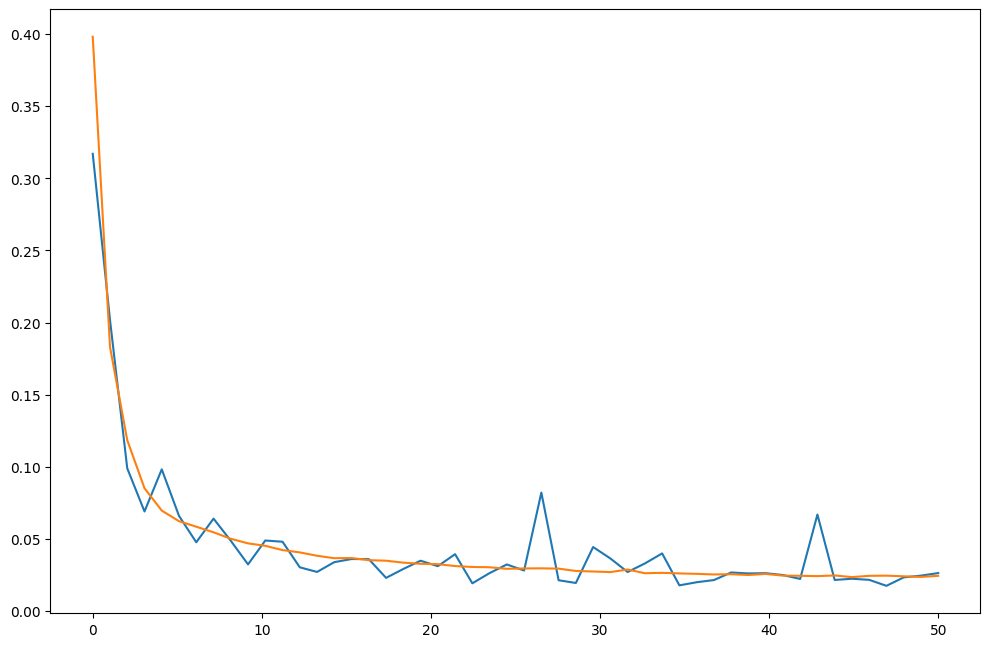

In [37]:
epochs = 50
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

-2.400000049083303 initial angle
tensor([-1.9500, -1.8000, -1.9500, -1.9500, -2.1000])
tensor([-2.0183, -1.8592, -2.0064, -2.0152, -2.1118], grad_fn=<MulBackward0>)


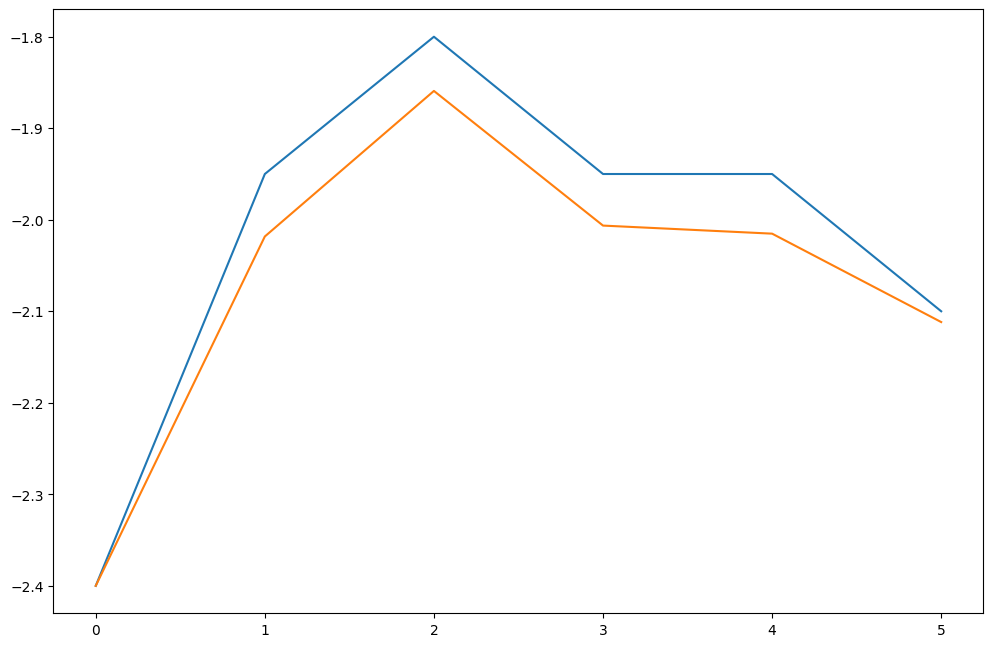

In [68]:
random_sample = test_set[randrange(len(test_set))]
initial_angle = random_sample[0][prev_data-1]*maxAngle
print(initial_angle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
torch_data_output = model(torch_data_input)*maxAngle
print(torch_data_output)

ls_good = [initial_angle] +[random_sample[1][i]*maxAngle for i in range(output_length)]
ls_pred = [initial_angle] +[torch_data_output[i] for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length+1), ls_good)
plt.plot(np.linspace(0, output_length, output_length+1), ls_pred)

In [69]:
torch.save(model, 'model.pth')

In [70]:
model = torch.load('model.pth')
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=940, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
    (5): Tanh()
  )
)
